In [81]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score, explained_variance_score


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd
import os
import numpy as np
import json
import glob
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from matplotlib import rcParams



### Load data

In [82]:
# Load the data
df = pd.read_csv('../../regioes/dadosFinais.csv', sep=';')
# print(df.columns)
print(df['codLocation'].unique())

local = 1711116  #1711116
df = df[df['codLocation'] == local]
df.head()

[1711105 1711107 1711110 1711111 1711115 1711116]


,Avaliacoes Total,Avaliacoes Apartamentos,Avaliacoes Moradias,Capital Divida Total,Capital Divida 3M,Capital Divida 6M,Capital Divida 12M,Juros Totais,Capital Amortizado,Unemployed population,...,Date,moving_avg_price_sell,exp_moving_avg_price_sell,price_to_rent_ratio,propriedades_unicas_rent,propriedades_unicas_sell,moving_avg_price_rent,exp_moving_avg_price_rent,moving_avg_Reducao_sell,moving_avg_Reducao_rent
1648,444,393,51.0,51817,97727,95476,94260.0,44,196,371.2,...,20180401,228502.000000,223989.808580,171.633929,-1.0,-1.0,1240.666667,1238.122829,17.666667,7.000000
1649,444,393,51.0,51817,97727,95476,94260.0,44,196,371.2,...,20180408,221680.000000,220666.904290,175.987045,2.0,-12.0,1236.333333,1236.561414,10.666667,1.333333
1650,444,393,51.0,51817,97727,95476,94260.0,44,196,371.2,...,20180415,213070.666667,215540.952145,154.603233,0.0,2.0,1276.000000,1298.780707,3.666667,0.833333
1651,444,393,51.0,51817,97727,95476,94260.0,44,196,371.2,...,20180422,213027.666667,213432.476072,165.874411,0.0,-1.0,1290.000000,1286.390354,5.666667,1.500000
1652,444,393,51.0,51817,97727,95476,94260.0,44,196,371.2,...,20180429,210368.000000,211398.738036,159.091945,1.0,-5.0,1317.000000,1301.195177,4.666667,1.166667


In [83]:
# Separar variáveis independentes (X) e dependente (y)
X = df.drop(columns=['Preço médio_sell'])

# y = df[['Date','Preço médio_sell']]
y = df['Preço médio_sell'] # drop the m2

train_size = 0.7
test_size = 0.2
valid_size = 0.1

total_size = len(df)
train_end = int(train_size * total_size)
test_end = int((train_size + test_size) * total_size)

X_train = X.iloc[:train_end]
X_test = X.iloc[train_end:test_end]
X_valid = X.iloc[test_end:]

y_train = y.iloc[:train_end]
y_test = y.iloc[train_end:test_end]
y_valid = y.iloc[test_end:]


print(f"Tamanho do conjunto de treinamento: {len(X_train)}")
print(f"Tamanho do conjunto de teste: {len(X_test)}")
print(f"Tamanho do conjunto de validação: {len(X_valid)}")

# Preparar dados para treino
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)

Tamanho do conjunto de treinamento: 231
Tamanho do conjunto de teste: 66
Tamanho do conjunto de validação: 34


### Train the model

In [71]:
param_grid = {
    'n_estimators': [200, 400, 500, 800],
    'max_features': [None, 0.5, 0.75], #'sqrt', 'log2', 
    'max_depth': [None, 5], # , 10, 20, 30
    'min_samples_split': [3, 5, 10], # , 15, 20
    'min_samples_leaf': [1, 2] # , 3, 4, 5
}
# Overtting: aumentar min_samples_split, min_samples_leaf
# diminuir max_depth, n_estimators, max_features

scoring = {
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'r2': 'r2',
    'explained_variance': make_scorer(explained_variance_score)
}


grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=10,  # número de folds para validação cruzada
                           n_jobs=-1,  # usar todos os núcleos disponíveis
                           verbose=3,  # nível de verbosidade
                           scoring=scoring,
                           refit='r2')

grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
best_rf_params = grid_search.best_params_

print("Best model:", best_rf_model)
print("Best params:", best_rf_params)

# Best params: {'max_depth': None, 'max_features': None, 
# 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 400}

# Best params: {'max_depth': None, 'max_features': None, 
# 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 800}

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best model: RandomForestRegressor(max_features=None, min_samples_split=3, n_estimators=500,
                      random_state=42)
Best params: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 500}


### Metrics

In [84]:
def calcular_metricas(y_real, y_pred, conjunto):
    mae = mean_absolute_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)
    mse = mean_squared_error(y_real, y_pred)
    acuracia = (1 - (mae / np.mean(y_real))) * 100
    print(f"{conjunto}: MAE: {mae:.2f}, R²: {r2:.2f}, MSE: {mse:.2f}, Acurácia: {acuracia:.2f}%")
    return mae, r2, mse, acuracia

In [90]:
best_rf_model = RandomForestRegressor(max_features=0.75, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=400, random_state=42).fit(X_train, y_train)

In [91]:
from sklearn.model_selection import TimeSeriesSplit

print("\nAvaliação sem TimeSeriesSplit:")
y_train_pred_rf = best_rf_model.predict(X_train)
y_test_pred_rf = best_rf_model.predict(X_test)

mae_train, r2_train, mse_train, acc_train = calcular_metricas(y_train, y_train_pred_rf, "Treino")
mae_test, r2_test, mse_test, acc_test = calcular_metricas(y_test, y_test_pred_rf, "Teste")


print("\nAvaliação com TimeSeriesSplit:")
tscv = TimeSeriesSplit(n_splits=5)

for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train_tscv, X_test_tscv = X.iloc[train_index], X.iloc[test_index]
    y_train_tscv, y_test_tscv = y.iloc[train_index], y.iloc[test_index]
    
    best_rf_model.fit(X_train_tscv, y_train_tscv)
    y_pred_tscv = best_rf_model.predict(X_test_tscv)
    y_pred_tscvtrain = best_rf_model.predict(X_train_tscv)

    
    calcular_metricas(y_train_tscv, y_pred_tscvtrain, f"TimeSeries Split train {i+1}")
    
    mae_testT, r2_testT, mse_testT, acc_testT = calcular_metricas(y_test_tscv, 
                                                              y_pred_tscv, 
                                                              f"TimeSeries Split test {i+1}")
    
    
    



Avaliação sem TimeSeriesSplit:
Treino: MAE: 429.87, R²: 1.00, MSE: 347322.38, Acurácia: 99.82%
Teste: MAE: 5974.38, R²: -0.49, MSE: 86825203.25, Acurácia: 97.85%

Avaliação com TimeSeriesSplit:
TimeSeries Split train 1: MAE: 556.37, R²: 0.98, MSE: 590880.41, Acurácia: 99.75%
TimeSeries Split test 1: MAE: 6151.55, R²: -1.76, MSE: 53392822.15, Acurácia: 97.35%
TimeSeries Split train 2: MAE: 492.54, R²: 0.99, MSE: 455754.41, Acurácia: 99.78%
TimeSeries Split test 2: MAE: 1296.25, R²: 0.27, MSE: 2720757.37, Acurácia: 99.45%
TimeSeries Split train 3: MAE: 426.74, R²: 0.99, MSE: 354451.60, Acurácia: 99.81%
TimeSeries Split test 3: MAE: 9990.18, R²: -0.79, MSE: 214322103.98, Acurácia: 96.01%
TimeSeries Split train 4: MAE: 430.02, R²: 1.00, MSE: 350599.24, Acurácia: 99.82%
TimeSeries Split test 4: MAE: 4825.35, R²: -5.84, MSE: 27097217.69, Acurácia: 98.24%
TimeSeries Split train 5: MAE: 413.92, R²: 1.00, MSE: 329476.31, Acurácia: 99.83%
TimeSeries Split test 5: MAE: 22749.44, R²: -4.60, MSE: 

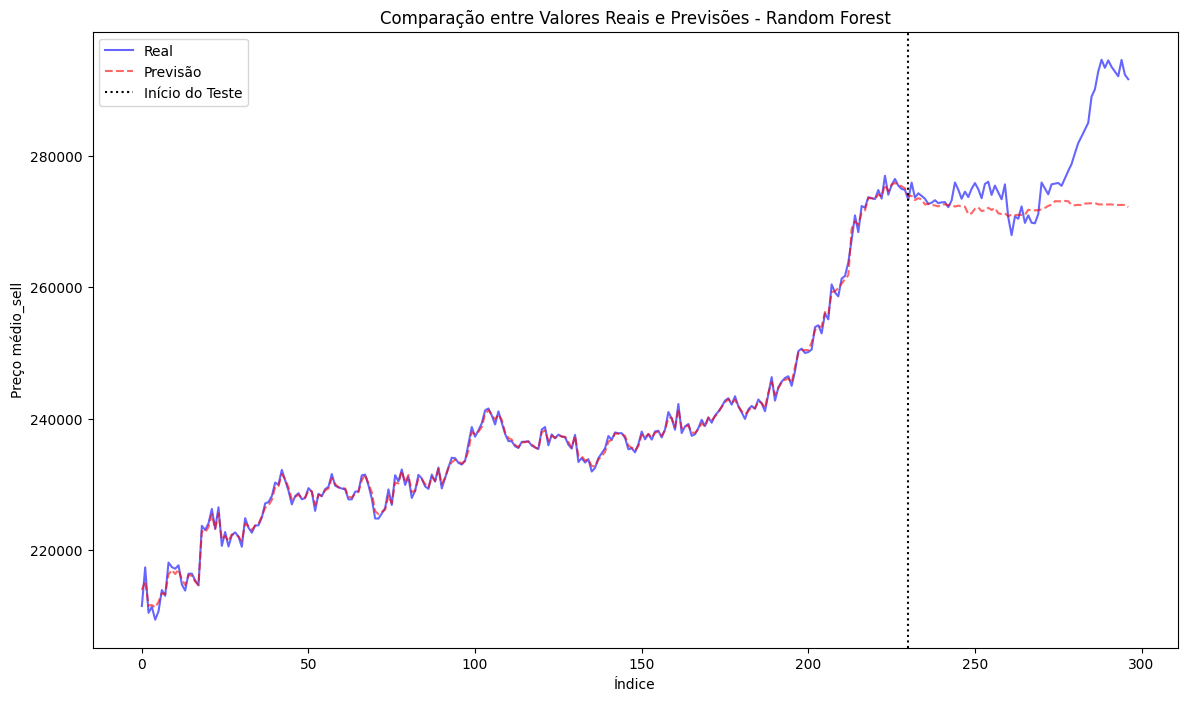

In [92]:

indices = np.concatenate([np.arange(len(y_train)), np.arange(len(y_train), len(y_train) + len(y_test))])
y_real = np.concatenate([y_train, y_test])
y_pred = np.concatenate([y_train_pred_rf, y_test_pred_rf])

plt.figure(figsize=(14, 8))
plt.plot(indices, y_real, color='blue', label='Real', alpha=0.6)
plt.plot(indices, y_pred, color='red', label='Previsão', linestyle='--', alpha=0.6)

plt.axvline(x=len(y_train) - 1, color='black', linestyle=':', label='Início do Teste')

plt.title('Comparação entre Valores Reais e Previsões - Random Forest')
plt.xlabel('Índice')
plt.ylabel('Preço médio_sell')
plt.legend()
plt.show()


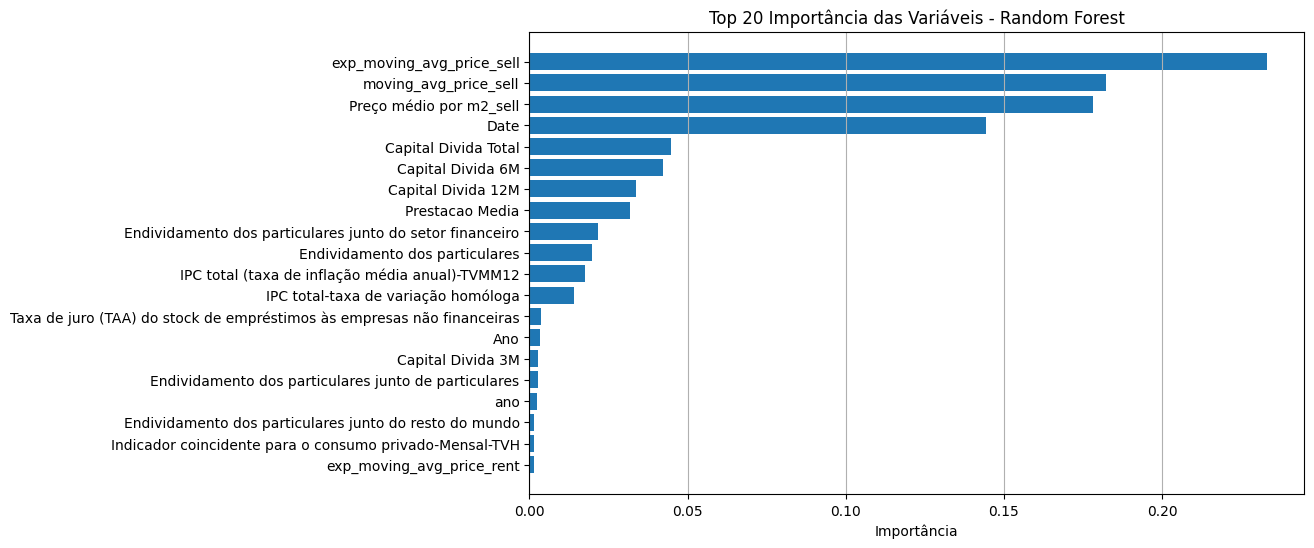

In [93]:

feature_importances = best_rf_model.feature_importances_
feature_names = X.columns  

sorted_idx = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_idx][:20] 
sorted_feature_names = feature_names[sorted_idx][:20]  

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importances)
plt.xlabel('Importância')
plt.title('Top 20 Importância das Variáveis - Random Forest')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

#### Dados de validacao

In [94]:
y_valid_pred_rf = best_rf_model.predict(X_valid)
mae_valid, r2_valid, mse_valid, acc_valid = calcular_metricas(y_valid, y_valid_pred_rf, "Validação")


Validação: MAE: 91348.21, R²: -152.88, MSE: 8404408914.78, Acurácia: 69.95%


c:\Users\ruben\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


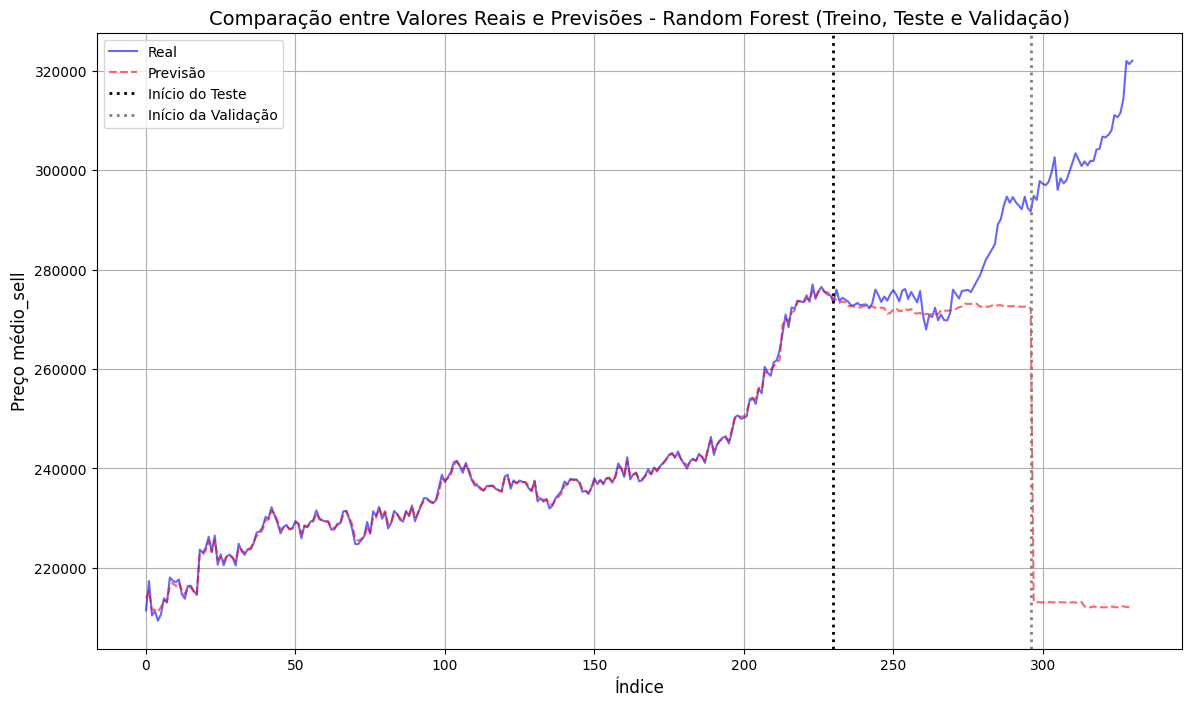

In [95]:
indices = np.concatenate([np.arange(len(y_train)), 
                          np.arange(len(y_train), len(y_train) + len(y_test)),
                          np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_valid))])

y_real = np.concatenate([y_train, y_test, y_valid])

y_pred = np.concatenate([y_train_pred_rf, y_test_pred_rf, y_valid_pred_rf])

plt.figure(figsize=(14, 8))
plt.plot(indices, y_real, color='blue', label='Real', alpha=0.6)
plt.plot(indices, y_pred, color='red', label='Previsão', linestyle='--', alpha=0.6)

plt.axvline(x=len(y_train) - 1, color='black', linestyle=':', linewidth=2, label='Início do Teste')
plt.axvline(x=len(y_train) + len(y_test) - 1, color='gray', linestyle=':', linewidth=2, label='Início da Validação')

plt.title('Comparação entre Valores Reais e Previsões - Random Forest (Treino, Teste e Validação)', fontsize=14)
plt.xlabel('Índice', fontsize=12)
plt.ylabel('Preço médio_sell', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### Results

In [98]:
resultados = {
    'Conjunto': ['Treino', 'Teste', 'Validação'],
    'MAE': [mae_train, mae_test, mae_valid],
    'R²': [r2_train, r2_test, r2_valid],
    'MSE': [mse_train, mse_test, mse_valid],
    'Acurácia (%)': [acc_train, acc_test, acc_valid]
}
resultados['Conjunto'].append('TimeSeries Split (Teste)')
resultados['MAE'].append(mae_testT)
resultados['R²'].append(r2_testT)
resultados['MSE'].append(mse_testT)
resultados['Acurácia (%)'].append(acc_testT)

resultados_df = pd.DataFrame(resultados)
resultados_df

,Conjunto,MAE,R²,MSE,Acurácia (%)
0,Treino,429.867417,0.998325,3.473224e+05,99.818633
1,Teste,5974.383614,-0.486295,8.682520e+07,97.850380
2,Validação,91348.210804,-152.880287,8.404409e+09,69.946266
3,TimeSeries Split (Teste),22749.441132,-4.600378,6.440319e+08,92.356419


In [97]:
import os
import json

def salvar_resultados_modelo(modelo_nome, localizacao,resultados_df):

    results_dict = resultados_df.to_dict(orient='records')
    results_dict_with_model = {
        "Modelo": modelo_nome,
        "Localização": localizacao,
        "Resultados": results_dict
    }


    directory = "modelos"
    json_filename = os.path.join(directory, 'resultadosModelos.json')

    if not os.path.exists(directory):
        os.makedirs(directory)


    if os.path.exists(json_filename):
        with open(json_filename, 'r') as json_file:
            existing_data = json.load(json_file)
    else:
        existing_data = []


    existing_data.append(results_dict_with_model)


    with open(json_filename, 'w') as json_file:
        json.dump(existing_data, json_file, indent=4)

    print(f"Dados salvos e adicionados ao arquivo {json_filename}")


salvar_resultados_modelo("Random Forest", local, resultados_df)

Dados salvos e adicionados ao arquivo modelos\resultadosModelos.json
